In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn import tree
from sklearn.metrics import confusion_matrix
import random
#Configuramos pandas para mostrarnos 20 filas
pd.set_option('display.max_rows', 20)
pd.set_option('display.min_rows', 20)

In [2]:
#Cargamos el fichero de cotizaciones seleccionando las columnas relevantes para el modelo
df=pd.read_csv('C:\\Users\\manuel.decesar\\Desktop\\data_labqt\\WIKI_PRICES_212b326a081eacca455e13140d7bb9db.csv', sep=',')[['ticker','date','adj_close','adj_volume']]  
print(len(df))
#fijamos los tipos de datos
df['date']=pd.to_datetime(df['date'])
print(len(df))
df

15389314
15389314


,ticker,date,adj_close,adj_volume
0,A,1999-11-18,30.018590,44739900.0
1,A,1999-11-19,27.548879,10897100.0
2,A,1999-11-22,30.018590,4705200.0
3,A,1999-11-23,27.460188,4274400.0
4,A,1999-11-24,28.012803,3464400.0
5,A,1999-11-26,28.101494,1237100.0
6,A,1999-11-29,28.742800,2914700.0
7,A,1999-11-30,28.783735,3083000.0
8,A,1999-12-01,29.295415,2115400.0
9,A,1999-12-02,30.107281,2195900.0


In [3]:
#df=df.reset_index()
#Filtrar tickers sin suficiente volumen
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
df=df[df['ticker'].isin(df_ticker_volume[df_ticker_volume>8.211].index)]
#Filtrar tickers sin suficientes cotizaciones
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
df=df[df['ticker'].isin(df_ticker_cot[df_ticker_cot>3.104].index)]
#Filtrar registros sin volumen
df=df[df['adj_close']>0]
#Filtro de fecha
df=df[df.date>='2001-01-01']
#Establecemos índice (ticker y fecha)
df=df.set_index(['ticker','date'])
print(len(df))
#df

9690726


(7.963, 8.493]     263
(8.493, 8.725]     263
(8.725, 8.92]      263
(8.92, 9.064]      262
(9.064, 9.225]     263
(9.225, 9.382]     263
(9.382, 9.574]     262
(9.574, 9.813]     263
(9.813, 10.14]     263
(10.14, 11.728]    263
Name: adj_volume, dtype: int64
total de tickers 2879
mediana de volumen ajustado por ticker 5086.000000000002


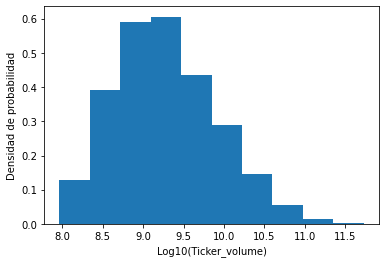

In [6]:
#Análisis volumen por ticker
%matplotlib inline
df_ticker_volume=np.log10(df.groupby(['ticker'])['adj_volume'].sum())
plt.hist(df_ticker_volume, density=True, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(Ticker_volume)');
#percentiles
print(pd.qcut(df_ticker_volume,10).value_counts().sort_index())
print('total de tickers',len(df_ticker_cot))
print('mediana de volumen ajustado por ticker',10**df_ticker_cot.median())


(3.1047, 3.5609]     876
(3.5609, 3.6369]    1745
(3.6369, 3.637]        7
Name: adj_close, dtype: int64
mediana de número de cotizaciones por ticker 4333.999999999999


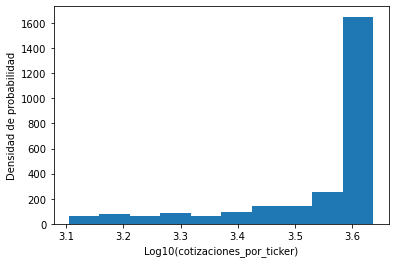

In [7]:
#Análisis cotizaciones por ticker
%matplotlib inline
df_ticker_cot=np.log10(df.groupby(['ticker'])['adj_close'].count())
plt.hist(df_ticker_cot, density=False, bins=10)  # density=False would make counts
plt.ylabel('Densidad de probabilidad')
plt.xlabel('Log10(cotizaciones_por_ticker)');
#percentiles
print(pd.qcut(df_ticker_cot,3).value_counts().sort_index())
print('mediana de número de cotizaciones por ticker',10**df_ticker_cot.median())

In [8]:
#Análisis nulos
print(df.reset_index()[df.reset_index().ticker.isnull()])
print(df.reset_index()[df.reset_index().date.isnull()])
print(df.reset_index()[df.reset_index().adj_close.isnull()])
print(df.reset_index()[df.reset_index().adj_volume.isnull()])

Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume]
Index: []
Empty DataFrame
Columns: [ticker, date, adj_close, adj_volume]
Index: []


(0.999, 1800.0]     446
(1800.0, 1890.0]    443
(1890.0, 2055.4]    443
(2055.4, 2148.4]    444
(2148.4, 2275.0]    445
(2275.0, 2333.0]    444
(2333.0, 2426.0]    443
(2426.0, 2515.0]    454
(2515.0, 2603.0]    435
(2603.0, 2628.0]    442
Name: adj_close, dtype: int64
número de fechas 4439
mediana de número de tickers por fecha 2275.0


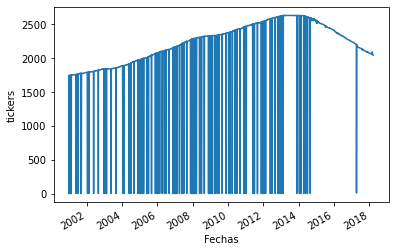

In [9]:
#Análisis discontinuidades de fechas
%matplotlib inline
df_date_tikers=df.groupby(['date'])['adj_close'].count()
df_date_tikers.plot()
plt.ylabel('tickers')
plt.xlabel('Fechas');
#percentiles
print(pd.qcut(df_date_tikers,10).value_counts().sort_index())
print('número de fechas',len(df_date_tikers))
print('mediana de número de tickers por fecha',df_date_tikers.median())

In [10]:
df_date_tikers[df_date_tikers<5][25:50]

date
2004-11-25    1
2004-12-24    1
2005-01-17    1
2005-02-21    1
2005-03-25    1
2005-05-30    1
2005-07-04    1
2005-09-05    1
2005-11-24    1
2005-12-26    1
             ..
2006-07-04    1
2006-09-04    1
2006-11-23    1
2006-12-25    1
2007-01-01    1
2007-01-02    1
2007-01-15    1
2007-02-19    1
2007-04-06    1
2007-05-28    1
Name: adj_close, Length: 25, dtype: int64

<AxesSubplot:xlabel='date'>

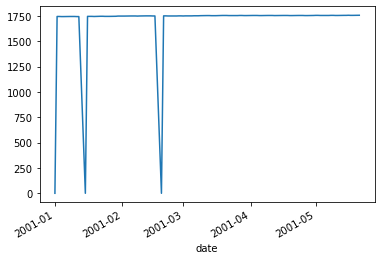

In [11]:
df_date_tikers[0:100].plot()

In [10]:
df.reset_index()[df.reset_index().date=='2004-01-19']

,ticker,date,adj_close,adj_volume
8323380,TAM,2004-01-19,0.385,132300.0


In [11]:
df.reset_index()[(df.reset_index().ticker=='TAM') & (df.reset_index().date>='2004-01-19')]

,ticker,date,adj_close,adj_volume
8323380,TAM,2004-01-19,0.385,132300.0
8323381,TAM,2004-01-20,0.390,143300.0
8323382,TAM,2004-01-21,0.385,264600.0
8323383,TAM,2004-01-26,0.390,132300.0
8323384,TAM,2004-01-27,0.385,198400.0
8323385,TAM,2004-01-28,0.390,11000.0
8323386,TAM,2004-02-09,0.370,55100.0
8323387,TAM,2004-02-10,0.380,99200.0
8323388,TAM,2004-02-11,0.380,66100.0
8323389,TAM,2004-02-16,0.375,0.0


In [12]:
df.reset_index()[(df.reset_index().ticker=='A') & (df.reset_index().date>='2004-01-19')]

,ticker,date,adj_close,adj_volume
763,A,2004-01-20,23.203006,3709300.0
764,A,2004-01-21,23.721509,4371400.0
765,A,2004-01-22,23.182539,3581400.0
766,A,2004-01-23,22.814129,2155400.0
767,A,2004-01-26,23.134782,3519500.0
768,A,2004-01-27,24.628889,21899200.0
769,A,2004-01-28,24.526553,5511000.0
770,A,2004-01-29,24.321880,3919600.0
771,A,2004-01-30,25.147392,5561100.0
772,A,2004-02-02,24.847206,3058100.0


In [12]:
#tickers posibles
print(np.unique(df.index.get_level_values(0)))
#fechas posibles
print(np.unique(df.index.get_level_values(1)))

['A' 'AAL' 'AAN' ... 'ZQK' 'ZTS' 'ZUMZ']
['2001-01-01T00:00:00.000000000' '2001-01-02T00:00:00.000000000'
 '2001-01-03T00:00:00.000000000' ... '2018-03-23T00:00:00.000000000'
 '2018-03-26T00:00:00.000000000' '2018-03-27T00:00:00.000000000']


In [13]:
#Filtrar muestra para desarrollo
#df=df.sort_values(by=['date'], ascending=False)[0:100000]
df=df.sort_values(by=['ticker'], ascending=False)[0:100000]
df=df.sort_values(by=['ticker','date'])
df=df.reset_index()
df=df.set_index(['ticker','date'])

In [15]:
#Calculamos el retorno respecto al día anterior: incremento relativo del ticker respecto el día anterior
df['return_d']=df.groupby(level='ticker')['adj_close'].pct_change()
#Calculamos el retorno respecto a la semana anterior: incremento relativo del ticker respecto a la semana anterior
df['return_w']=df.groupby(level='ticker')['adj_close'].pct_change(periods=5)
#Calculamos el retorno respecto al mes anterior: incremento relativo del ticker respecto el mes anterior
df['return_m']=df.groupby(level='ticker')['adj_close'].pct_change(periods=20)
#Calculamos el retorno respecto al año anterior: incremento relativo del ticker respecto el año anterior
df['return_y']=df.groupby(level='ticker')['adj_close'].pct_change(periods=252)
#df

In [17]:
#Volatilidad semanal del retorno diario
df['volatility_w_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_d'].shift(periods=1).rolling(5).std())
#Volatilidad mensual del retorno diario
df['volatility_m_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_m'].shift(periods=1).rolling(20).std())
#Volatilidad anual del retorno diario
df['volatility_y_rd']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: grp['return_y'].shift(periods=1).rolling(252).std())
#df

In [18]:
#Cierre ajustado promediado semanal
df['adj_close_m_pw']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.shift(periods=1).rolling(5).mean())
#Cierre ajustado promediado mensual
df['adj_close_m_pm']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.shift(periods=1).rolling(20).mean())
#Cierre ajustado promediado anual
df['adj_close_m_py']=df.groupby(level='ticker')['adj_close'].apply(lambda grp: grp.shift(periods=1).rolling(252).mean())

In [19]:
#Retorno respecto al cierre ajustado promediado semanal
df['return_m_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pw'])/x['adj_close_m_pw'], axis=1)
#Retorno respecto al cierre ajustado promediado mensual
df['return_m_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_pm'])/x['adj_close_m_pm'], axis=1)
#Retorno respecto al cierre ajustado promediado anual
df['return_m_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_m_py'])/x['adj_close_m_py'], axis=1)

In [21]:
#Cierre ajustado promediado ponderado por volumen semanal
df['adj_close_vwm_pw']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).shift(periods=1).rolling(5).sum()/grp.shift(periods=1)['adj_volume'].rolling(5).sum())
#Cierre ajustado promediado ponderado por volumen mensual
df['adj_close_vwm_pm']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).shift(periods=1).rolling(20).sum()/grp.shift(periods=1)['adj_volume'].rolling(20).sum())
#Cierre ajustado promediado ponderado por volumen anual
df['adj_close_vwm_py']=df.reset_index('ticker').groupby('ticker').apply(lambda grp: (grp['adj_close']*grp['adj_volume']).shift(periods=1).rolling(252).sum()/grp.shift(periods=1)['adj_volume'].rolling(252).sum())
#df.loc['AMZN']

In [22]:
#Retorno respecto al cierre ajustado promediado ponderado semanal
df['return_vwm_pw']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pw'])/x['adj_close_vwm_pw'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado mensual
df['return_vwm_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pm'])/x['adj_close_vwm_pm'], axis=1)
df#Retorno respecto al cierre ajustado promediado ponderado anual
df['return_vwm_py']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_py'])/x['adj_close_vwm_py'], axis=1)
#df

<ipython-input-22-84b7ff031221>:4: RuntimeWarning: invalid value encountered in double_scalars
  df['return_vwm_pm']=df.apply(lambda x: (x['adj_close']-x['adj_close_vwm_pm'])/x['adj_close_vwm_pm'], axis=1)


In [21]:
#me faltarían los tipos de tickers y los días de la semana


In [23]:
#Calculamos el retorno al día siguiente: incremento relativo del ticker en el día siguiente
df['return_f_d']=df.groupby(level='ticker')['adj_close'].pct_change().shift(periods=-1)

In [24]:
#Calculamos target (retorno>0)
df['return_gt_0']=df.apply(lambda x: 1 if x['return_f_d']>0 else 0, axis=1)

In [25]:
#Seleccionar date (para validación), features finales y target
df=df.reset_index()[['date','return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py','return_gt_0']]
df

,date,return_d,return_w,return_m,return_y,return_m_pw,return_m_pm,return_m_py,volatility_w_rd,volatility_m_rd,volatility_y_rd,return_vwm_pw,return_vwm_pm,return_vwm_py,return_gt_0
0,2002-05-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2002-05-14,0.041581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2002-05-15,-0.021439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,2002-05-16,0.014102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2002-05-17,-0.001738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,2002-05-20,-0.015174,0.016170,NaN,NaN,-0.008862,NaN,NaN,NaN,NaN,NaN,-0.008954,NaN,NaN,1
6,2002-05-21,0.004547,-0.019961,NaN,NaN,-0.007487,NaN,NaN,0.025302,NaN,NaN,-0.007737,NaN,NaN,1
7,2002-05-22,0.016595,0.018131,NaN,NaN,0.013080,NaN,NaN,0.014447,NaN,NaN,0.013113,NaN,NaN,1
8,2002-05-23,0.011625,0.015644,NaN,NaN,0.021172,NaN,NaN,0.012855,NaN,NaN,0.021211,NaN,NaN,0
9,2002-05-24,-0.016381,0.000746,NaN,NaN,0.001294,NaN,NaN,0.012392,NaN,NaN,0.000418,NaN,NaN,0


In [26]:
#Zscore (normalizar? por día? para todos los tickets?)
#df['zscore']=df.groupby('date')['adj_close'].transform(lambda grp: (grp - grp.mean())/ grp.std())
#df

In [26]:
#Filtramos NaN
print(len(df))
df=df.dropna()
print(len(df))

100000
83768


In [83]:
#Construimos un modelo de arbol de decisión
lim=int(len(df)*.8)
X_train, y_train = df[['return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py']][0:lim],df[['return_gt_0']][0:lim]
X_test, y_test = df[['return_d','return_w','return_m','return_y','return_m_pw','return_m_pm','return_m_py','volatility_w_rd','volatility_m_rd','volatility_y_rd','return_vwm_pw','return_vwm_pm','return_vwm_py']][lim:-1],df[['return_gt_0']][lim:-1]
model = tree.DecisionTreeClassifier(max_depth=5)
model = model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))
print(confusion_matrix(y_test, model.predict(X_test)))
tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel() 
print(tn, fp, fn, tp)
total=tn+ fp+ fn+ tp
print('total',total)
print(tn/total, fp/total, fn/total, tp/total)

0.5270689706628465
0.5209813167790843
[[6589 1963]
 [6062 2139]]
6589 1963 6062 2139
total 16753
0.3933026920551543 0.117173043633976 0.36184563958693966 0.12767862472393005


[Text(155.70661764705883, 203.85, 'return_d <= -0.001\ngini = 0.5\nsamples = 67014\nvalue = [34284, 32730]\nclass = 0'),
 Text(80.14411764705883, 176.67000000000002, 'return_y <= -0.64\ngini = 0.5\nsamples = 31605\nvalue = [15663, 15942]\nclass = 1'),
 Text(32.82352941176471, 149.49, 'volatility_y_rd <= 0.02\ngini = 0.485\nsamples = 1706\nvalue = [999, 707]\nclass = 0'),
 Text(30.635294117647064, 122.31, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = 1'),
 Text(35.01176470588236, 122.31, 'return_d <= -0.019\ngini = 0.485\nsamples = 1702\nvalue = [999, 703]\nclass = 0'),
 Text(17.50588235294118, 95.13, 'return_vwm_py <= -0.79\ngini = 0.49\nsamples = 1295\nvalue = [740, 555]\nclass = 0'),
 Text(8.75294117647059, 67.94999999999999, 'volatility_m_rd <= 0.084\ngini = 0.424\nsamples = 82\nvalue = [57, 25]\nclass = 0'),
 Text(4.376470588235295, 40.77000000000001, 'return_m_pm <= -0.421\ngini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = 1'),
 Text(2.1882352941176473, 13.590000000000003, 'g

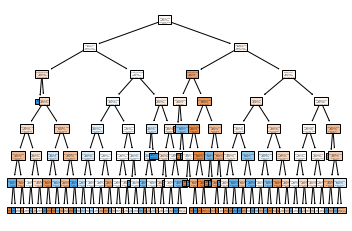

In [73]:
tree.plot_tree(model, 
                   feature_names=X_train.columns,  
                   class_names=['0', '1'],
                   filled=True)

In [74]:
len(y_test)

16753

In [75]:
y_0=[0]*len(y_test)
print(sum(y_0==y_test.return_gt_0.values)/len(y_test))
print(confusion_matrix(y_test, y_0))

0.5104757356891303
[[8552    0]
 [8201    0]]


In [76]:
y_1=[1]*len(y_test)
print(sum(y_1==y_test.return_gt_0.values)/len(y_test))
print(confusion_matrix(y_test, y_1))

0.4895242643108697
[[   0 8552]
 [   0 8201]]


In [77]:
y_random = []
for i in range(len(y_test)):
    n = random.randint(0,1)
    y_random.append(n)
sum(y_random==model.predict(X_test))/len(y_test)
print(sum(y_random==y_test.return_gt_0.values)/len(y_test))
print(confusion_matrix(y_test, y_random))

0.498656956962932
[[4293 4259]
 [4140 4061]]


In [78]:
y_pred=model.predict(X_test)
print(sum(y_pred==y_test.return_gt_0.values)/len(y_test))
print(confusion_matrix(y_test, y_pred))
sum(y_test.return_gt_0.values==y_pred)/len(y_test)

0.5169820330687042
[[4729 3823]
 [4269 3932]]


0.5169820330687042

Retornos diarios


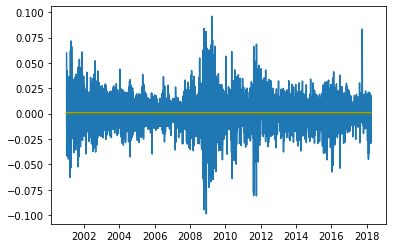

Retornos diarios acumulados sin reinvertir


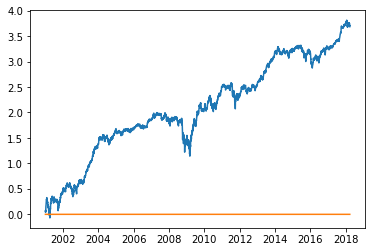

Retornos diarios acumulados reinvirtiendo


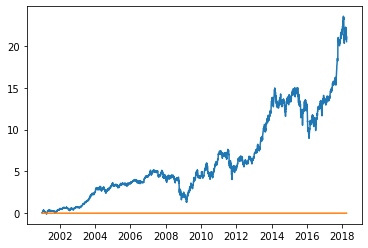

In [27]:
#Retornos diarios estrategia básica (estrategia de repartir a partes iguales entre todos los tickers diariamente)
s=df.groupby('date')['return_d'].mean()
print('Retornos diarios')
plt.plot(s)
plt.plot(s.index,[s.mean()]*len(s.index))
plt.plot(s.index,[0]*len(s.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha sin reinvertir los retornos diarios
print('Retornos diarios acumulados sin reinvertir')
cs=s.cumsum()
plt.plot(cs)
plt.plot(cs.index,[0]*len(cs.index))
plt.show() 
#Retornos diarios acumulados hasta la fecha reinvirtiendo los retornos diarios
print('Retornos diarios acumulados reinvirtiendo')
rcs=(s+1).cumprod()
plt.plot(rcs-1)
plt.plot(rcs.index,[0]*len(rcs.index))
plt.show()

Siguiente:

features:tipo de ticker (sector), día de la semana, macd,zscore del precio (power point)

pca

tree model (like in 0013_init_example)

more comlex model 

crossvalidation hiperparámetros